# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

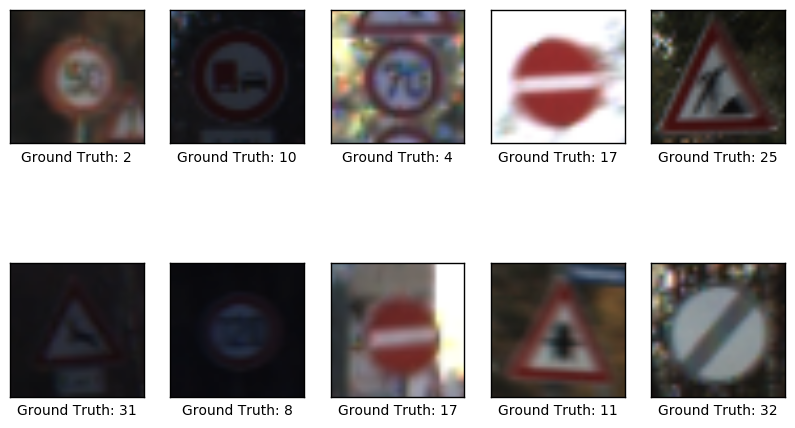

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
fig = plt.figure(figsize=(10, 6))

image_seq = np.random.randint(1,len(X_train),10)

for ind,val in enumerate(image_seq):
    img = fig.add_subplot(2,5,ind+1)
    plt.imshow(X_train[val-1])
    #Add corresponding label
    img.set_xlabel("Ground Truth: {0}".format(y_train[val-1]))
    #Remove the axis ticks
    img.set_xticks([])
    img.set_yticks([])

plt.show()


Distribution of labels in training data


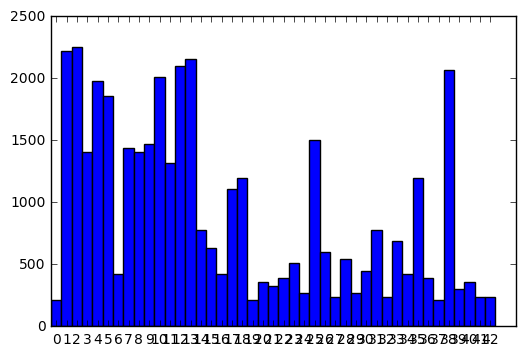

In [4]:
from collections import Counter

ctr = Counter(sorted(y_train))
print('Distribution of labels in training data')
labels, values = zip(*(ctr.items()))

indexes = np.arange(len(labels))
width =1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from pylab import rcParams
from tqdm import tqdm_notebook
import matplotlib.image as mpimg
from zipfile import ZipFile
import time
from datetime import timedelta
import math
import tensorflow as tf
import time
import os
import cv2
# Grayscale conversion
'''
Weighted average approach utilizing numpy functions. No need for OpenCV
Y' = 0.299 R + 0.587 G + 0.114 B 
'''
X_train_gray = np.dot(X_train[...][...,:3],[0.299,0.587,0.114])
X_test_gray = np.dot(X_test[...][...,:3],[0.299,0.587,0.114])


train_features = (X_train_gray - np.mean(X_train_gray))/np.std(X_train_gray)
test_features =(X_test_gray - np.mean(X_test_gray))/np.std(X_test_gray)

In [6]:
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** I have just converted the image to grayscale.<br>I then normalized the values buy using np.mean and np.std since I don't want high variance in the data.
Finally, as the input was sorted by class, I randomized it to avoid overfitting.

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.1,
    random_state=832289)


train_features, train_labels = shuffle(train_features, train_labels)
valid_features, valid_labels = shuffle(valid_features, valid_labels)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** I took 10% of the training data as validation data, which seemed enough to not overfit the data.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# Define Parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 256
display_step = 5

n_input = len(train_features[0])**2
# n_classes already defined = 43

n_hidden_layer = 256 # width of the layer

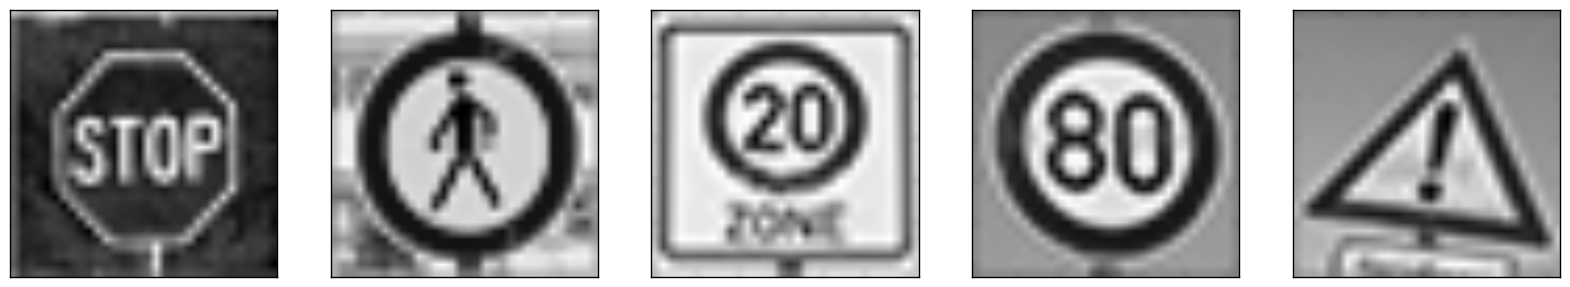

(5, 32, 32)


In [9]:
#load another 5 test images
images = os.listdir("testdata/")

fig = plt.figure(figsize=(20, 8))

test_images = []

# Read in test images
for idx,val in enumerate(images):
    #reading in an image
    image = mpimg.imread('testdata/' + images[idx])
    if len(image.shape) > 2 and image.shape[2] == 4:
        #convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        test_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))


# Create subplots in figure
for r in range(1,len(test_images)+1):
    img = fig.add_subplot(1,5,r)
    plt.imshow(test_images[r-1],cmap='gray')
    img.set_xticks([])
    img.set_yticks([])

plt.show()
test_images_norm = (test_images - np.mean(test_images))/np.std(test_images)
test_images_flat = np.reshape(test_images_norm, [-1, n_input])

print(test_images_norm.shape)

In [10]:
# Weights and biases

weights = {
    'hidden_layer_1': tf.Variable(tf.truncated_normal([n_input, n_hidden_layer], mean = 0.0, stddev = 0.01)),
    'hidden_layer_2': tf.Variable(tf.truncated_normal([n_hidden_layer, n_hidden_layer], mean = 0.0, stddev = 0.01)),
    'out': tf.Variable(tf.truncated_normal([n_hidden_layer, n_classes], mean = 0.0, stddev = 0.01))
}

biases = {
    'hidden_layer_1': tf.Variable(tf.truncated_normal([n_hidden_layer])),
    'hidden_layer_2': tf.Variable(tf.truncated_normal([n_hidden_layer])),
    'out': tf.Variable(tf.truncated_normal([n_classes]))
}

In [11]:
# Flatten/Reshape data
X_test_gray_flat = np.reshape(test_features, [-1, n_input])
train_features_flat = np.reshape(train_features, [-1, n_input])
valid_features_flat = np.reshape(valid_features, [-1, n_input])

In [12]:
# Input graph for TF
network_input = tf.placeholder("float", [None, n_input])
network_output = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

In [13]:
# Hidden layer 1 with ReLU activation
hidden_layer_1 = tf.add(tf.matmul(network_input, weights['hidden_layer_1']), biases['hidden_layer_1'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)
hidden_layer_1 = tf.nn.dropout(hidden_layer_1, keep_prob)

In [14]:
# Hidden layer 2 with ReLU activation
hidden_layer_2 = tf.add(tf.matmul(hidden_layer_1, weights['hidden_layer_2']), biases['hidden_layer_2'])
hidden_layer_2 = tf.nn.relu(hidden_layer_2)
hidden_layer_2 = tf.nn.dropout(hidden_layer_2, keep_prob)

In [15]:
logits = tf.add(tf.matmul(hidden_layer_2, weights['out']), biases['out'])
label_pred = tf.nn.softmax(logits)
label_pred_class = tf.argmax(label_pred, 1)
# Check if predictions are correct.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(network_output, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Cost function and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, network_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [16]:
def plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cls_pred):
    test_cls = np.argmax(test_labels, axis=1)
    cm = confusion_matrix(y_true=test_cls,
                              y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)
    
    rcParams['figure.figsize'] = 13,13
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def print_test_accuracy():
    test_cls = np.argmax(test_labels, axis=1)
    cls_pred = np.zeros(shape=n_test, dtype=np.int)
    i = 0

    while i < n_test:
        j = min(i + batch_size, n_test)

        batch_x = X_test_gray_flat[i:j]
        batch_y = test_labels[i:j]
        
        feed_dict={network_input: batch_x, network_output: batch_y, keep_prob: 1.0}

        cls_pred[i:j] = session.run(label_pred_class, feed_dict=feed_dict)

        i = j
    print(cls_pred)
    correct = (test_cls == cls_pred)
    correct_sum = correct.sum()

    acc = float(correct_sum) / n_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, n_test))

    plot_confusion_matrix(cls_pred=cls_pred)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The very first network I put together was a simple three layer linear neural network with a two hidden layer with 256 neurons in each of them. It allowed me to education and familiarize myself with Python, Numpy, Matplotlib and TensorFlow.<br>
    
    **NOTE** I've never coded in Python, Numpy, Jupyter Notebook, TensorFlow or Matplotlib until now so it took me longer than desired to get this far but I am satisfied with my first attempt and I am more comfortable now than I was when I first started.

Epoch: 0001 cost= 2.842351492
Epoch: 0006 cost= 0.752775118
Epoch: 0011 cost= 0.549699220
Epoch: 0016 cost= 0.467158638
Epoch: 0021 cost= 0.415952313
Epoch: 0026 cost= 0.372754959
Epoch: 0031 cost= 0.364186447
Epoch: 0036 cost= 0.336762217
Epoch: 0041 cost= 0.315866423
Epoch: 0046 cost= 0.320013601
Epoch: 0051 cost= 0.299402336
Epoch: 0056 cost= 0.318154591
Epoch: 0061 cost= 0.294070010
Epoch: 0066 cost= 0.292160775
Epoch: 0071 cost= 0.274958258
Epoch: 0076 cost= 0.271604130
Epoch: 0081 cost= 0.267624622
Epoch: 0086 cost= 0.274164451
Epoch: 0091 cost= 0.259247768
Epoch: 0096 cost= 0.254454623
Optimization Finished!
Total time:115.23863387107849 seconds
Training Accuracy: 0.924734
Validation Accuracy: 0.963785
Test Accuracy: 0.896438
[16  1 38 ...,  3  5 10]
Accuracy on Test-Set: 89.6% (11322 / 12630)
[[ 46   2   0 ...,   0   0   0]
 [  1 669  18 ...,   5   0   0]
 [  0  16 709 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  69   0   0]
 [  0   0   0 ...,   0  41   0]
 [  0   0   0 ...,   

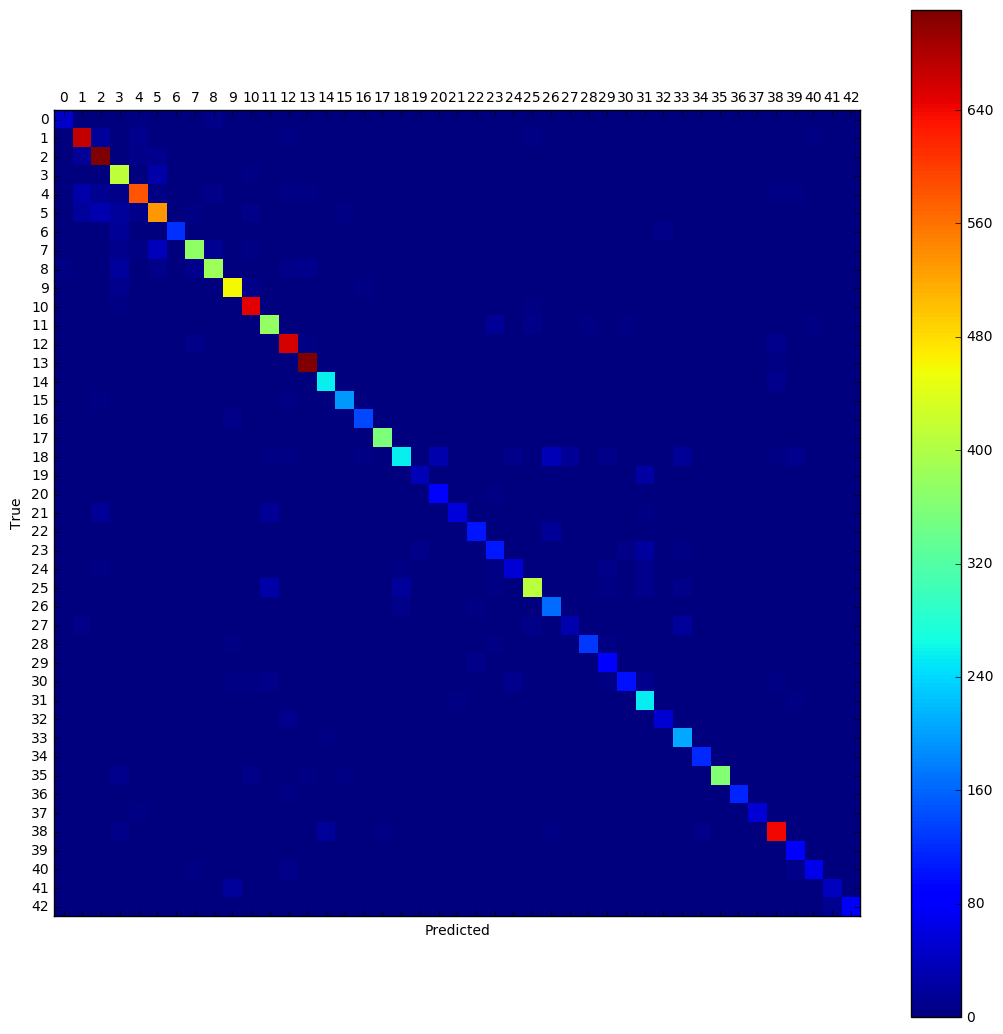

In [17]:
### Train your model here.
### Feel free to use as many code cells as needed.


# Initialize variables
init = tf.global_variables_initializer()
total_time=0;
# Launch graph
with tf.Session() as session:
    session.run(init)
    
    # Training cycle
    for epochs in range(training_epochs):
        start_time = time.time()
        avg_cost = 0.
        total_batch = int(len(train_features)/batch_size)
        
        for i in range(total_batch):
            idx_l = i*batch_size
            idx_h = idx_l + batch_size
            
            batch_x = train_features_flat[idx_l:idx_h]
            batch_y = train_labels[idx_l:idx_h]
                        
            _,c = session.run([optimizer, cost], feed_dict = {network_input: batch_x, network_output: batch_y, keep_prob: 0.5})
            
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if epochs % display_step == 0:
            print("Epoch:", '%04d' % (epochs+1), "cost=", \
                "{:.9f}".format(avg_cost))
        end_time = time.time() - start_time  
        total_time=total_time+end_time
    print("Optimization Finished!")
    print("Total time:%s seconds" %total_time)
    # Calculate accuracy
    training_accuracy = session.run(accuracy, feed_dict = 
                                            {network_input: train_features_flat, network_output: train_labels, keep_prob: 0.5})
            
    validation_accuracy = session.run(accuracy, feed_dict = 
                                            {network_input: valid_features_flat, network_output: valid_labels, keep_prob: 1.0})
    
    test_accuracy = session.run(accuracy, feed_dict = 
                                            {network_input: X_test_gray_flat, network_output: test_labels, keep_prob: 1.0})
    print("Training Accuracy:", training_accuracy)
    print("Validation Accuracy:", validation_accuracy)
    print("Test Accuracy:", test_accuracy)
    print_test_accuracy()
    for i in range(len(test_images_norm)):
        new_predictions = session.run(label_pred, feed_dict = {network_input: test_images_flat, keep_prob: 1.0})
    
    
    topkv2=session.run(tf.nn.top_k(label_pred, 2), feed_dict={network_input: test_images_flat, keep_prob: 1.0})

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I have used Adam optimizer. My batch size is 256 with learning rate of 0.001 and I have run model for 100 epochs only.<br> All above paramters were selected using trial and error method

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** I started the architecture with only single hidden layer and then moved towards two hidden layers.<br>I didn't use more than 100 epochs as the accuracy wasn't improving after that.Also I could train it with CNN but I didn't wanted to waste my time on training on AWS.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** I have plotted the images in grayscale above only. Four signs were chosen because they look similar to images from the database and one was random one.<br>
I wanted to see if they would get classified correctly.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** So 3 images were classified correctly and other were not classified. This can be confirmed by mapping classes from signnames.csv to the class having maximum probability.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [18]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
print(new_predictions)
print(topkv2)

[[  2.89985993e-31   2.71777244e-16   6.23631161e-19   4.06434839e-20
    2.06662069e-21   9.56704576e-21   5.63181853e-42   1.04519390e-27
    9.82671704e-26   2.61292978e-15   7.30057528e-15   5.81516008e-21
    4.74075633e-14   1.21890318e-13   1.00000000e+00   8.63893667e-17
    2.02908018e-42   4.48221946e-11   3.27998906e-14   3.55187493e-29
    1.80581932e-16   3.90233594e-24   2.09803475e-15   1.98822311e-21
    4.82963750e-31   2.38600020e-13   1.59488879e-16   5.54191542e-39
    2.40877256e-20   3.40909806e-23   4.38402453e-21   2.18032812e-24
    6.78627849e-28   4.35195601e-14   1.55797285e-16   1.93234023e-18
    7.86057762e-28   1.23477487e-21   7.78706197e-11   9.10383233e-28
    6.54729490e-21   1.42932443e-43   0.00000000e+00]
 [  4.18821148e-18   2.73663736e-05   1.56849311e-10   3.38845329e-21
    1.70157274e-11   9.22885720e-19   1.80030966e-34   2.91453635e-16
    3.98614987e-29   1.52793791e-19   8.85330311e-24   3.50991562e-11
    2.08774582e-01   2.36160541e-16 

**Answer:** In the above cell you can see that Softmax probability has been displayed as an array.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.